In [2]:
# 필요한 Module import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random
import os

# sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# 사실은 one-hot encopding처리는
# pandas를 이용해서 더 많이 처리합니다.
from sklearn.model_selection import train_test_split
# 이상치 처리를 위해
from scipy import stats
from sklearn.impute import SimpleImputer


# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import TensorBoard

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as lightning

2025-10-31 10:32:10.089973: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 10:32:10.250819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-31 10:32:10.330290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-31 10:32:10.330800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-31 10:32:10.456827: I tensorflow/core/platform/cpu_feature_gua

# Seed 설정

In [3]:
def seed_everything(seed=42):

    # 1. 환경변수
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 2. Python, Numpy
    random.seed(seed)
    np.random.seed(seed)
    
    # 3. TensorFlow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(seed)
    
    # 4. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # PyTorch 1.8+ 권장

    # 5. PyTorch Lightning
    lightning.seed_everything(seed, workers=True)

    print(f"Seeds set to {seed}")

seed_everything(42)

Seed set to 42


Seeds set to 42


### Data 호출

In [4]:
test_df = pd.read_csv('./data/test.csv')
train_df = pd. read_csv('./data/train.csv')

In [5]:
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'],
                         axis=1,
                         inplace=False)
train_df

# 결측치와 각 컬럼의 값이 어떻게 구성되어 있는지 확인
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

### 결측치 제거

In [21]:
# ② 결측치 확인
# --------------------------
print("\n✅ [Train 결측치 요약]")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

print("\n✅ [Test 결측치 요약]")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])


✅ [Train 결측치 요약]
Age         177
Cabin       687
Embarked      2
dtype: int64

✅ [Test 결측치 요약]
Age       86
Fare       1
Cabin    327
dtype: int64


In [22]:
# 숫자형 결측치 처리
num_imputer = SimpleImputer(strategy='median')
train_df[['Age','Fare']] = num_imputer.fit_transform(train_df[['Age','Fare']])
test_df[['Age', 'Fare']] = num_imputer.transform(test_df[['Age', 'Fare']])

# 문자형 결측치 처리
str_imputer = SimpleImputer(strategy='most_frequent')
train_df[['Embarked']] = str_imputer.fit_transform(train_df[['Embarked']])
test_df[['Embarked']] = str_imputer.transform(test_df[['Embarked']])

In [23]:
# 처리 결과 확인

print("\n✅ [처리 후 Train 결측치 확인]")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

print("\n✅ [처리 후 Test 결측치 확인]")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])


✅ [처리 후 Train 결측치 확인]
Cabin    687
dtype: int64

✅ [처리 후 Test 결측치 확인]
Cabin    327
dtype: int64


### 이상치 제거

In [24]:
# IQR 적용할 수치형 칼럼 선택
num_cols = ['Age', 'Fare']

# IQR 계산
Q1 = train_df[num_cols].quantile(0.25)
Q3 = train_df[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("하한값 :", lower_bound)
print("상한값 :", upper_bound)

하한값 : Age      2.500
Fare   -26.724
dtype: float64
상한값 : Age     54.5000
Fare    65.6344
dtype: float64


In [25]:
outlier_condition = ((train_df[num_cols] < lower_bound) | (train_df[num_cols] > upper_bound))

# 각 컬럼별 이상치 개수 확인
print("\n[이상치 개수]")
print(outlier_condition.sum())

# 이상치가 포함된 행 보기
print("\n[이상치 샘플]")
display(train_df[outlier_condition.any(axis=1)].head())


[이상치 개수]
Age      66
Fare    116
dtype: int64

[이상치 샘플]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
15,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q


In [26]:
train_df_clean = train_df[(train_df[num_cols] >= lower_bound).all(axis=1) &
(train_df[num_cols] <= upper_bound).all(axis=1)].copy()

In [27]:
# 데이터 스케일링
from sklearn.preprocessing import StandardScaler

num_cols = ['Age', 'Fare']
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

In [28]:
# 데이터 인코딩
from sklearn.preprocessing import LabelEncoder

str_cols = ['Sex', 'Embarked']
for col in str_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col]= le.transform(test_df[col])

### 머신러닝 모델 구축

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [30]:
# 독립변수 (x) : Survive 칼럼을 제외한 모든 칼럼
# 독립변수 (y) : Survive 칼럼
drop_cols = ['Name', 'Ticket', 'Cabin']
X = train_df.drop(['Survived'] + drop_cols, axis=1)
Y = train_df['Survived']

X_test = test_df.drop(drop_cols, axis=1)


# 데이터  분리
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

# 모델학습
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

# 얘측 및 평가
y_pred_test = model.predict(X_test)
print(y_pred_test)

submission = pd.DataFrame({
    'PassengerId' : test_df['PassengerId'],
    'Survived' : y_pred_test
})

print(submission.head())

submission.to_csv('./submission.csv', index=False)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0
 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0
 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [31]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# 1️⃣ K-Fold 객체 생성
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2️⃣ 사용할 모델 정의
model = LogisticRegression(max_iter=20000)

# 3️⃣ 교차검증 실행
scores = cross_val_score(model, X, Y, cv=kf, scoring='accuracy')

# 4️⃣ 결과 출력
print("Fold별 정확도:", scores)
print("평균 정확도:", scores.mean())


Fold별 정확도: [0.80446927 0.79213483 0.84269663 0.76966292 0.78089888]
평균 정확도: 0.7979725064339966


✅ 검증 정확도: 0.7597765363128491

📋 상세 리포트:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       110
           1       0.70      0.65      0.68        69

    accuracy                           0.76       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.76      0.76      0.76       179



/home/kiyong/anaconda3/envs/data_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:59:41] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


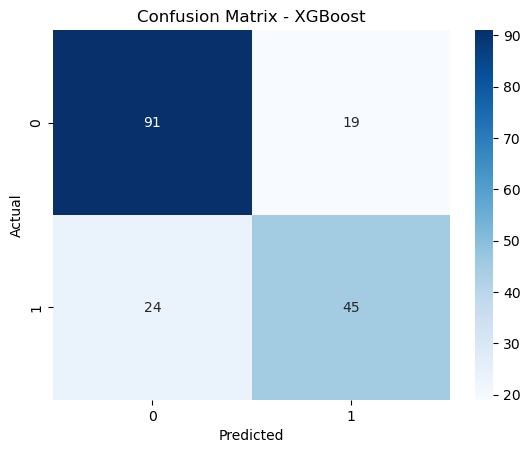

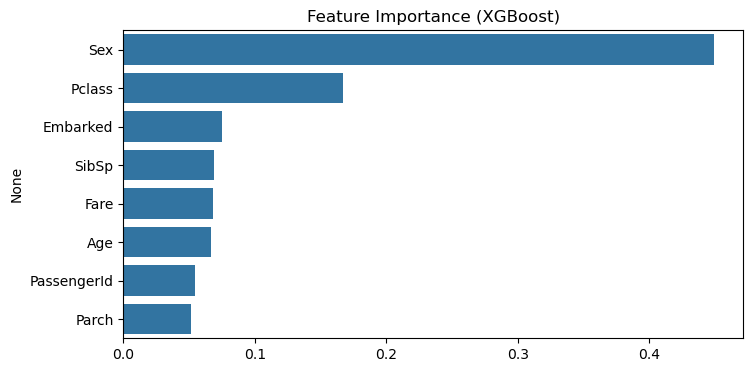

🚀 submission_xgboost.csv 파일 생성 완료!


In [32]:
# ======================================================
# [📦 XGBoost 비선형 모델 - Titanic 생존예측]
# ======================================================

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------
# 1️⃣ 데이터 준비
# ------------------------------
drop_cols = ['Name', 'Ticket', 'Cabin']
X = train_df.drop(['Survived'] + drop_cols, axis=1)
y = train_df['Survived']

X_test = test_df.drop(drop_cols, axis=1)

# ------------------------------
# 2️⃣ 학습/검증 데이터 분리
# ------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 3️⃣ 비선형 모델 (XGBoost)
# ------------------------------
xgb = XGBClassifier(
    n_estimators=500,       # 트리 개수
    max_depth=4,            # 트리 깊이
    learning_rate=0.05,     # 학습률 (낮을수록 안정적)
    subsample=0.8,          # 데이터 샘플 비율
    colsample_bytree=0.8,   # 특성 샘플 비율
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

# ------------------------------
# 4️⃣ 예측 및 검증
# ------------------------------
y_pred = xgb.predict(X_val)
print("✅ 검증 정확도:", accuracy_score(y_val, y_pred))
print("\n📋 상세 리포트:\n", classification_report(y_val, y_pred))

# ------------------------------
# 5️⃣ 혼동행렬 시각화
# ------------------------------
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------------------------------
# 6️⃣ Feature Importance (변수 중요도)
# ------------------------------
feature_importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance (XGBoost)")
plt.show()

# ------------------------------
# 7️⃣ test.csv 예측 및 저장
# ------------------------------
y_pred_test = xgb.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred_test
})

submission.to_csv('./submission_xgboost.csv', index=False)
print("🚀 submission_xgboost.csv 파일 생성 완료!")


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

Epoch 1/100


/home/kiyong/anaconda3/envs/data_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5506 - loss: 0.6929 - val_accuracy: 0.6816 - val_loss: 0.6368
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7346 - loss: 0.5934 - val_accuracy: 0.7598 - val_loss: 0.5643
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7430 - loss: 0.5342 - val_accuracy: 0.7542 - val_loss: 0.5160
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7598 - loss: 0.5068 - val_accuracy: 0.7709 - val_loss: 0.4887
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7893 - loss: 0.4745 - val_accuracy: 0.7877 - val_loss: 0.4706
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7795 - loss: 0.4668 - val_accuracy: 0.7877 - val_loss: 0.4605
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7893 - loss: 0.4521 - val_accuracy: 0.8045 - val_loss: 0.4523
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7992 - loss: 0.4406 - val_accuracy: 0.8045 - val_loss: 0.4

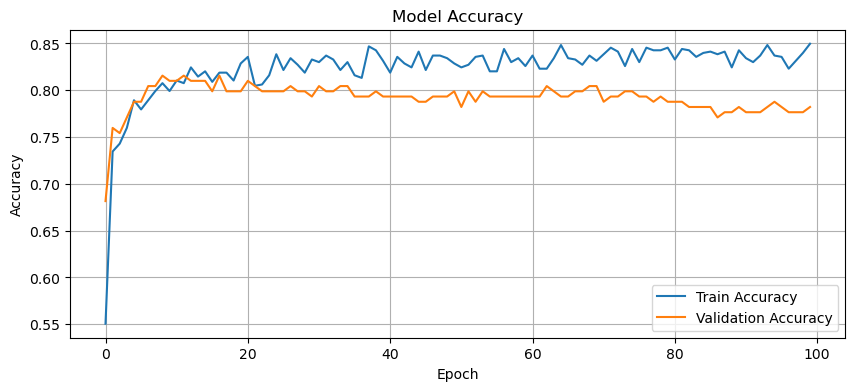

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
✅ 검증 정확도: 0.7821229050279329

📋 상세 리포트:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       110
           1       0.77      0.62      0.69        69

    accuracy                           0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🚀 submission_deep_learning.csv 파일 생성 완료!


In [34]:
# ------------------------------
# 1️⃣ 데이터 준비
# ------------------------------
drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
X = train_df.drop(['Survived'] + drop_cols, axis=1)
y = train_df['Survived']

X_test = test_df.drop(drop_cols, axis=1)

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 2️⃣ 딥러닝 모델 정의
# ------------------------------
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # 생존 여부(0/1) → sigmoid
])

# ------------------------------
# 3️⃣ 컴파일
# ------------------------------
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ------------------------------
# 4️⃣ 학습
# ------------------------------
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# ------------------------------
# 5️⃣ 학습 결과 시각화
# ------------------------------
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# 6️⃣ 검증 데이터 평가
# ------------------------------
val_pred = (model.predict(X_val) > 0.5).astype(int)
print("✅ 검증 정확도:", accuracy_score(y_val, val_pred))
print("\n📋 상세 리포트:\n", classification_report(y_val, val_pred))

# ------------------------------
# 7️⃣ test.csv 예측 및 제출 파일 생성
# ------------------------------
y_pred_test = (model.predict(X_test_scaled) > 0.5).astype(int)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred_test.flatten()
})

submission.to_csv('./submission_deep_learning.csv', index=False)
print("🚀 submission_deep_learning.csv 파일 생성 완료!")

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
